In [0]:
# Please note that this notebook is ran on Google colab in GPU runtime environment

In [0]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# Download the pre-trained inception v3 model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-05-04 05:05:21--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  74.4MB/s    in 1.1s    

2020-05-04 05:05:22 (74.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [0]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [0]:
# We are specifying in parameters - 1. not to include system defined default weights; 2. In the top we have few fully connected layers which we are ignoring by mentioning include_top=False 
pre_trained_model = InceptionV3(input_shape=(150,150,3), weights=None, include_top=False) 

In [0]:
# Load the weights downloaded earlier to the model
pre_trained_model.load_weights(local_weights_file)

In [0]:
# All the layers in the pre_trained_model need not be trained again
for layer in pre_trained_model.layers:
  layer.trainable = False

# pre_trained_model.summary()

In [9]:
# Fetch a specific layer from the model.summary()
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)

# Define last_layer's output as the last_output
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [11]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2020-05-04 05:06:34--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 2404:6800:4008:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  75.3MB/s    in 0.9s    

2020-05-04 05:06:35 (75.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
# Training the model
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 17s - loss: 0.3699 - accuracy: 0.8620 - val_loss: 0.1293 - val_accuracy: 0.9480
Epoch 2/20
100/100 - 17s - loss: 0.2114 - accuracy: 0.9225 - val_loss: 0.1054 - val_accuracy: 0.9620
Epoch 3/20
100/100 - 16s - loss: 0.2303 - accuracy: 0.9185 - val_loss: 0.1137 - val_accuracy: 0.9590
Epoch 4/20
100/100 - 16s - loss: 0.1880 - accuracy: 0.9290 - val_loss: 0.0981 - val_accuracy: 0.9640
Epoch 5/20
100/100 - 16s - loss: 0.1839 - accuracy: 0.9360 - val_loss: 0.1455 - val_accuracy: 0.9550
Epoch 6/20
100/100 - 17s - loss: 0.1847 - accuracy: 0.9320 - val_loss: 0.1512 - val_accuracy: 0.9560
Epoch 7/20
100/100 - 16s - loss: 0.1852 - accuracy: 0.9325 - val_loss: 0.0981 - val_accuracy: 0.9690
Epoch 8/20
100/100 - 16s - loss: 0.1613 - accuracy: 0.9440 - val_loss: 0.2278 - val_accuracy: 0.9470
Epoch 9/20
100/100 - 16s - loss: 0.1649 - accuracy: 0.9470 - val_loss: 0.1261 - val_accuracy: 0.9660
Epoch 10/20
100/100 - 16s - loss: 0.1309 - accuracy: 0.9525 - val_loss: 0.2020 - val_accura

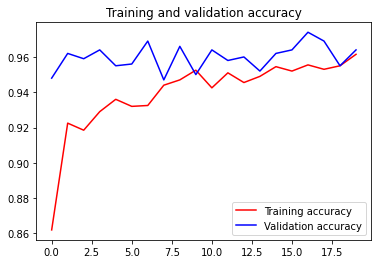

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()